## Chap 03 Classification

### 데이터 불러오기

In [2]:
## load dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # 데이터셋이 이미지 -> 데이터 프레임에 안 맞음 as_frame=False는 넘파이 배열로 데이터를 받음

In [3]:
X, y = mnist.data, mnist.target 

In [4]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
X.shape # (행, 열) -> 28x28픽셀 이므로 784

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

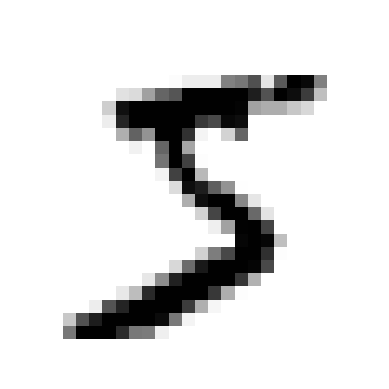

In [8]:
import matplotlib.pyplot as plt

## 함수 정의
def plot_digit(image_data):
    image = image_data.reshape(28, 28) # 28x28 배열로 크기 바꾸기 -> 784개(= 28×28) 길이의 1차원 배열로 저장되어 있는 것을 2차원(28행 × 28열)으로 전환
    plt.imshow(image, cmap="binary") # binary 흑백 컬러맵 사용
    plt.axis("off")
    
some_digit = X[0] # X데이터 묶음에서 첫 번째 샘플 가져오기
plot_digit(some_digit)
plt.show

In [9]:
y[0]

'5'

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 이진 분류기 훈련

In [11]:
## 5와 5가 아닌 것을 구분하는 이진 분류기

y_train_5 = (y_train == '5') # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [12]:
## 확률적 경사 하강법(SGD) 분류기

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # 훈련 데이터로 모델 학습

SGDClassifier(random_state=42)

### 성능 측정

In [13]:
## K-fold 교차 검증

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # 3개의 폴드

for train_index, test_index in skfolds.split(X_train, y_train_5): # 훈련 데이터(X_train, y_train_5)를 (train_index, test_index) 두 가지 인덱스로 나눠줌
    # train_index는 훈련에 쓸 데이터 위치, test_index는 검증에 쓸 데이터 위치
    clone_clf = clone(sgd_clf) # clone은 같은 모델을 새로 복제해서 쓸 수 있게 해주는 함수
    # 훈련용 추출
    X_train_folds = X_train[train_index] # 훈련 입력 데이터
    y_train_folds = y_train_5[train_index] # 훈련 정답 라벨
    # 검증용 추출
    X_test_fold = X_train[test_index] # 검증 입력 데이터
    y_test_fold = y_train_5[test_index] # 검증 정답 라벨
    clone_clf.fit(X_train_folds, y_train_folds) # 훈련 데이터로 학습
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) # 예측한 값(y_pred)과 실제 정답(y_test_fold)을 비교해서 맞은 개수 카운트 -> 맞으면 True(1), 틀리면 False(0)
    print(n_correct / len(y_pred)) # 정확도 계산

0.95035
0.96035
0.9604


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
## 5아님 음성클래스로 분류하는 더미 분류기 만들기
## 더미 분류기 : 실제로 학습하지 않고, 아무 의미 없는 방식으로 예측 -> 비교용 기준 모델 만들 때 사용(내가 만든 모델이 최소한 이것보다 나아야 한다)

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # False -> True로 예측된 것이 없음

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.90965, 0.90965, 0.90965])

- accuracy(정확도)를 분류기의 성능 측정 지표로 사용하지 않음 
- 특히, 어떤 클래스가 다른 것보다 월등히 많은 경우와 같이 불균형 데이터셋을 사용할 때 

In [17]:
## 오차 행렬
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred) # 타깃 클래스 = y_train_5, 예측 클래스 = y_train_pred
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [ ]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우 -> 진짜 양성, 진짜 음성만 가지고 있음
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [ ]:
## 정밀도와 재현율

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 5로 판별된 이미지 중 83.7%만 정확
recall_score(y_train_5, y_train_pred) # 전체 숫자 5에서 65.1%만 감지

0.6511713705958311

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [23]:
## 정밀도/재현율 트레이드오프

y_scores = sgd_clf.decision_function([some_digit])
y_scores


array([2164.22030239])

In [24]:
# 임계값이 0일 때

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# 임계값이 3000일 때

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# 적절한 임계값 구하기

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") # 결정 점수 반환하도록 지정

In [27]:
from sklearn.metrics import precision_recall_curve # 가능한 모든 임계값에 대해 정밀도와 재현율 계산

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

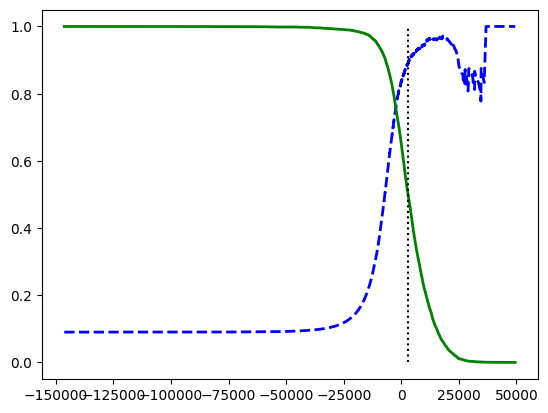

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임계값")
[...] # 그리드, 범례, 축, 레이블, 동그라미를 추가
plt.show()

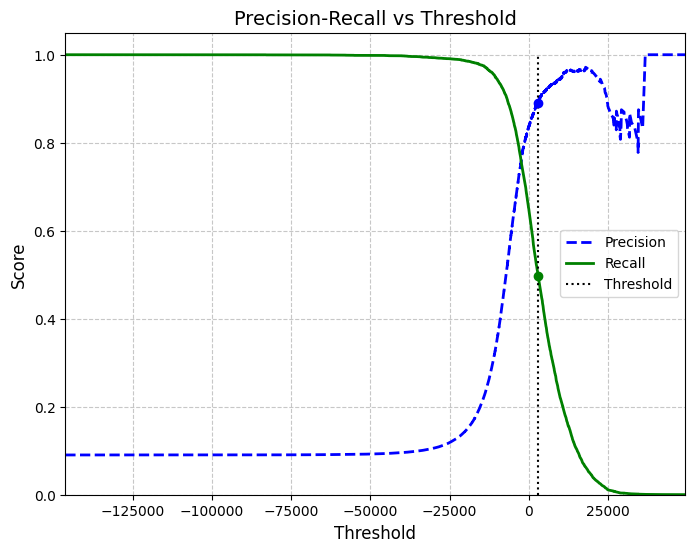

In [30]:

import numpy as np
plt.figure(figsize=(8, 6))

# 정밀도와 재현율 곡선
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# 임계값 수직선
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")

# 특정 지점 동그라미 표시
plt.plot([threshold], [precisions[np.argmax(thresholds >= threshold)]], "bo")  # Precision 점
plt.plot([threshold], [recalls[np.argmax(thresholds >= threshold)]], "go")     # Recall 점

# 보조 설정
plt.grid(True, linestyle="--", alpha=0.7)       # 그리드 추가
plt.xlabel("Threshold", fontsize=12)            # x축 레이블
plt.ylabel("Score", fontsize=12)                # y축 레이블
plt.title("Precision-Recall vs Threshold", fontsize=14)
plt.legend(loc="best", fontsize=10)             # 범례
plt.ylim(0, 1.05)                               # y축 범위
plt.xlim(min(thresholds), max(thresholds))      # x축 범위

plt.show()

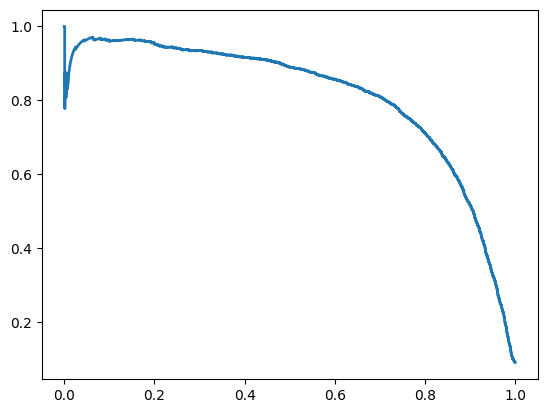

In [31]:
plt.plot(recalls, precisions, linewidth=2, label="정밀도/재현율 곡선")
[...] # 그리드, 범례, 축, 레이블, 동그라미를 추가
plt.show()

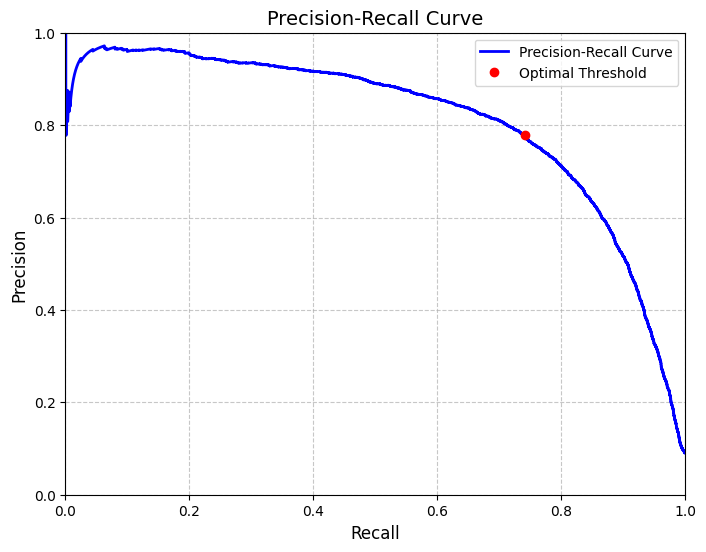

In [34]:
plt.figure(figsize=(8, 6))

# PR 곡선
plt.plot(recalls, precisions, linewidth=2, label="Precision-Recall Curve", color="b")

# 특정 지점(예: 최대 F1 score 지점)을 동그라미로 표시
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)  # F1 계산
best_idx = np.argmax(f1_scores)
plt.plot(recalls[best_idx], precisions[best_idx], "ro", label="Optimal Threshold")

# 보조 설정
plt.grid(True, linestyle="--", alpha=0.7)       # 그리드
plt.xlabel("Recall", fontsize=12)      # x축 레이블
plt.ylabel("Precision", fontsize=12)  # y축 레이블
plt.title("Precision-Recall Curve", fontsize=14)
plt.legend(loc="best", fontsize=10)             # 범례
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [ ]:
# 정밀도 90% 달성하는 값 찾기
idx_for_90_precision = (precisions >= 0.90).argmax() # 0.9가 되는 가장 낮은 임계값 찾기 -> 최댓값의 첫번째 인덱스 반환
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [36]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [38]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### ROC 곡선

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)